Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
zip_file = pathlib.Path("/content/gdrive/MyDrive/upgrad/CNN_assignment.zip")

import zipfile
import os

# The name of the uploaded file

# The directory where you want to extract the files
extract_to_dir = '/content/cnn_assignment'

# Ensure the directory exists
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f"Extracted {zip_file} to {extract_to_dir}")

Extracted /content/gdrive/MyDrive/upgrad/CNN_assignment.zip to /content/cnn_assignment


In [4]:
data_dir_train =  pathlib.Path("/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test =  pathlib.Path("/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

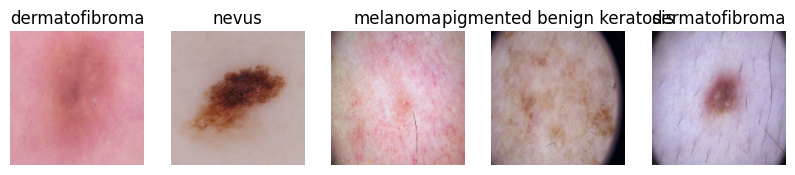

In [10]:
# Function to visualize images from the dataset
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(10, 8))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(f"{class_names[label.numpy()[0]]}")
        plt.axis('off')
    plt.show()

# Load dataset (assuming train_ds is already loaded)
# If train_ds is large, you might want to use `.take()` to limit the number of images shown
visualize_images(train_ds)




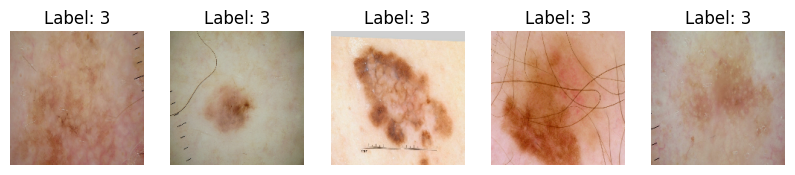

In [11]:
# Visualize the batchess with melanoma class
def filter_by_label(dataset, target_label):
    def predicate(image, label):
        return tf.equal(label, target_label)

    # Apply filter to dataset
    filtered_ds = dataset.filter(lambda image, label: tf.reduce_any(predicate(image, label)))
    return filtered_ds

# Function to visualize images from the filtered dataset
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    count = 0
    for i, (image, label) in enumerate(dataset):
      image_np = image.numpy().astype('uint8')
      # Only plot images with label 3
      if label.numpy()[0] == 3:
            plt.subplot(1, num_images, count + 1)
            plt.imshow(image_np[0])
            plt.title(f"Label: {label.numpy()[0]}")
            plt.axis('off')
            count += 1

        # Stop if we have plotted enough images
            if count >= num_images:
              break
    plt.show()

# Filter dataset for label value 3
filtered_ds = filter_by_label(train_ds, target_label=3)
# Visualize the images
visualize_images(filtered_ds)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
def create_model():
  num_classes = 9
  input_shape = [img_height, img_width, 3]
  model = models.Sequential([
        # Rescaling Layer
        layers.Rescaling(1./255, input_shape=input_shape),  # Normalize to [0, 1]
        # First Convolutional Layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Layer
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the output and add Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # For multi-class classification
    ])
  return model
model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
def compile_model(model):
  model.compile(optimizer='adam',
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

compile_model(model)

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312,777 (100.38 MB)

 Trainable params: 26,312,777 (100.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.2131 - loss: 2.3725 - val_accuracy: 0.3727 - val_loss: 1.6408
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4165 - loss: 1.5542 - val_accuracy: 0.4981 - val_loss: 1.3055
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4999 - loss: 1.3404 - val_accuracy: 0.5575 - val_loss: 1.2023
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6079 - loss: 1.0756 - val_accuracy: 0.5909 - val_loss: 1.0808
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6763 - loss: 0.8960 - val_accuracy: 0.6919 - val_loss: 0.8696
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7620 - loss: 0.6721 - val_accuracy: 0.7068 - val_loss: 0.8376
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7997 - loss: 0.5614 - val_accuracy: 0.7498 - val_loss: 0.7516
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8482 - loss: 0.4187 - va

### Visualizing training results

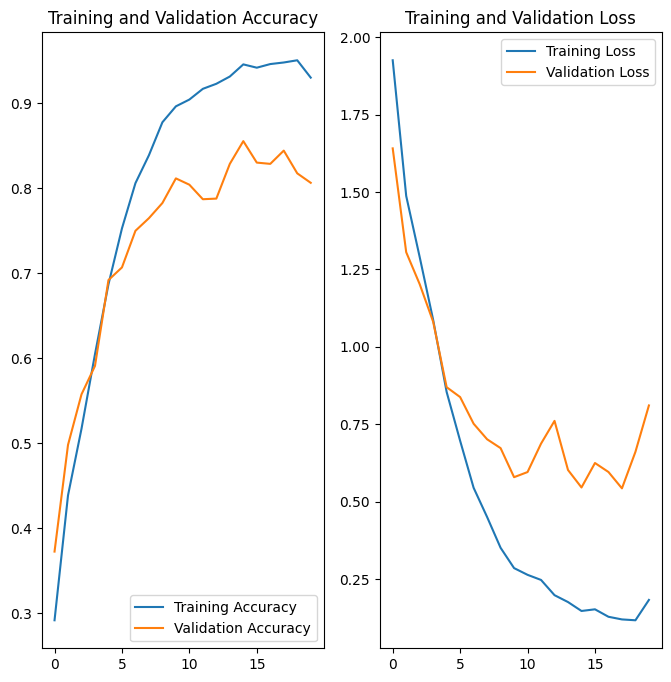

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here


# Define a data augmentation function with rotation and zoom
def augment_image(image, label):
    # Apply random horizontal and vertical flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Apply random contrast and brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Apply random zoom
    scale = tf.random.uniform([], minval=0.8, maxval=1.2)  # Random scale between 80% and 120%
    new_height = int(img_height * scale)
    new_width = int(img_width * scale)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)  # Resize back to original dimensions

    return image, label

# Apply the augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

num_samples = sum(1 for _ in augmented_train_ds.unbatch())
num_batches = num_samples // batch_size

print(num_batches)

print(batch_size)


168
32


In [19]:
import tensorflow as tf

# Assuming train_ds and augmented_ds are TensorFlow datasets
# Get the first batch from each dataset to check the shape
for images, labels in train_ds.take(1):
    print("Shape of images in train_ds:", images.shape)
    print("Shape of labels in train_ds:", labels.shape)

for images, labels in augmented_train_ds.take(1):
    print("Shape of images in augmented_ds:", images.shape)
    print("Shape of labels in augmented_ds:", labels.shape)


Shape of images in train_ds: (32, 180, 180, 3)
Shape of labels in train_ds: (32,)
Shape of images in augmented_ds: (32, 180, 180, 3)
Shape of labels in augmented_ds: (32,)


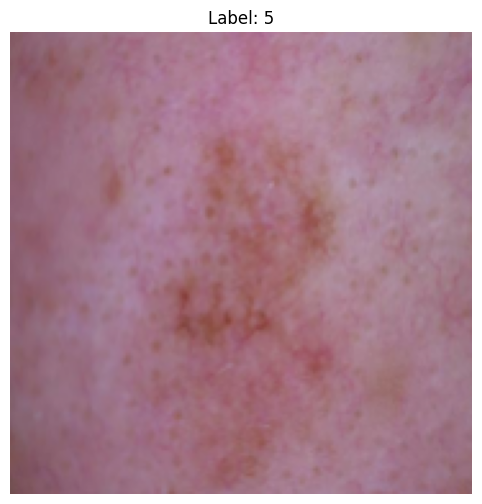

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Visualize some augmented images
def visualize_images(dataset, num_images=1):
    plt.figure(figsize=(10, 6))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(f"Label: {label.numpy()[0]}")
        plt.axis('off')
    plt.show()

# Display augmented images
visualize_images(augmented_train_ds, 1)

















### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
input_shape = [img_height, img_width, 3]
num_classes = 9
## Your code goes here
model = models.Sequential([
      # Rescaling Layer
      layers.Rescaling(1./255, input_shape=input_shape),  # Normalize to [0, 1]
      # First Convolutional Layer
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Second Convolutional Layer
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Third Convolutional Layer
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Flatten the output and add Dense Layers
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.4),  # Dropout layer with a dropout rate of 30%
      layers.Dense(num_classes, activation='softmax')  # For multi-class classification
  ])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312,777 (100.38 MB)

 Trainable params: 26,312,777 (100.38 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.2050 - loss: 2.2067 - val_accuracy: 0.3348 - val_loss: 1.6664
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.3870 - loss: 1.6104 - val_accuracy: 0.4343 - val_loss: 1.4914
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.4227 - loss: 1.4991 - val_accuracy: 0.4439 - val_loss: 1.4262
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4285 - loss: 1.4821 - val_accuracy: 0.4536 - val_loss: 1.4176
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.4361 - loss: 1.4317 - val_accuracy: 0.4922 - val_loss: 1.3203
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.4856 - loss: 1.3354 - val_accuracy: 0.4722 - val_loss: 1.3403
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.4949 - loss: 1.3495 - val_accuracy: 0.5071 - val_loss: 1.2347
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5053 - loss: 1.2461 - v

### Visualizing the results

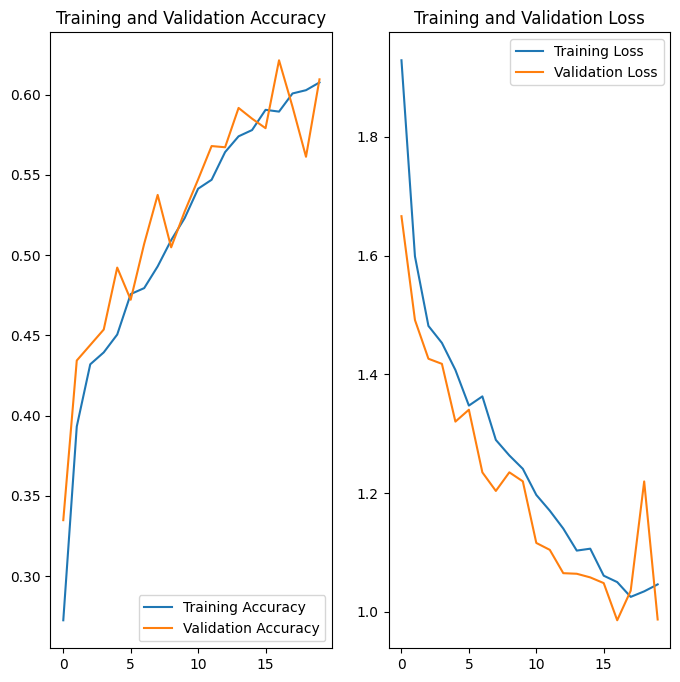

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

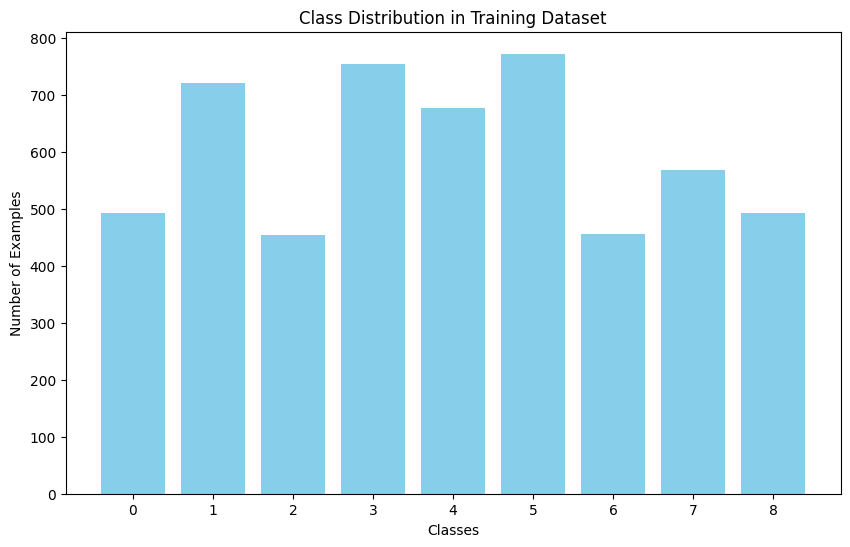

In [25]:
from collections import Counter
## Your code goes here.
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

def count_classes(dataset):
    class_counts = Counter()

    # Iterate through the dataset
    for images, labels in dataset:
        # Flatten labels from the batch
        labels = tf.reshape(labels, [-1]).numpy()  # Flatten and convert to NumPy array
        class_counts.update(labels)

    return class_counts

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Examples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(classes)  # Ensure all class labels are shown
    plt.show()

# Assuming `train_ds` is your batched training dataset
class_distribution = count_classes(train_ds)
plot_class_distribution(class_distribution)



#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset = str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7B20691390>: 100%|██████████| 500/500 [00:20<00:00, 24.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7B337B3490>: 100%|██████████| 500/500 [00:23<00:00, 20.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7AE2123160>: 100%|██████████| 500/500 [00:20<00:00, 24.58 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2313x1985 at 0x7A7B207C8220>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7A7B201A8D90>: 100%|██████████| 500/500 [01:15<00:00,  6.61 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A7AC1E4B490>: 100%|██████████| 500/500 [00:15<00:00, 32.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A7B412D4E80>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A7B42B49720>: 100%|██████████| 500/500 [00:15<00:00, 33.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A7B401664A0>: 100%|██████████| 500/500 [00:16<00:00, 30.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000024.jpg_d9613a5c-1cdd-4b18-9fbd-c90efb6f205e.jpg',
 '/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000088.jpg_61e02500-6fb5-427f-9388-94c713973a7a.jpg',
 '/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000083.jpg_375fc221-e361-44b5-b5ac-5a27d7fdca1a.jpg',
 '/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000316.jpg_82ffbcab-d71f-458f-839e-5ddd1891053a.jpg',
 '/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000021.jpg_2b4f288c-1a33-43e4-89da-abd92ad81874.jpg',
 '/content/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_df = df2

In [33]:
new_df['Label'].value_counts()

,count
Label,
nevus,1000
dermatofibroma,1000
melanoma,1000
basal cell carcinoma,1000
vascular lesion,1000
actinic keratosis,1000
pigmented benign keratosis,1000
squamous cell carcinoma,1000
seborrheic keratosis,1000


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
modelAfterAugmentation = models.Sequential([
      # Rescaling Layer
      layers.Rescaling(1./255, input_shape=input_shape),  # Normalize to [0, 1]
      # First Convolutional Layer
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Second Convolutional Layer
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Third Convolutional Layer
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),

      # Flatten the output and add Dense Layers
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.4),  # Dropout layer with a dropout rate of 50%
      layers.Dense(num_classes, activation='softmax')  # For multi-class classification
  ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
compile_model(modelAfterAugmentation)

#### **Todo:**  Train your model

In [39]:
epochs = 50
## Your code goes here, use 50 epochs.
history = modelAfterAugmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 214ms/step - accuracy: 0.2429 - loss: 1.9827 - val_accuracy: 0.4143 - val_loss: 1.5509
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 62s 152ms/step - accuracy: 0.4337 - loss: 1.4618 - val_accuracy: 0.5358 - val_loss: 1.2208
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.5429 - loss: 1.2122 - val_accuracy: 0.6382 - val_loss: 0.9606
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.6342 - loss: 0.9854 - val_accuracy: 0.7085 - val_loss: 0.7814
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - accuracy: 0.7208 - loss: 0.7784 - val_accuracy: 0.7379 - val_loss: 0.6848
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 151ms/step - accuracy: 0.7632 - loss: 0.6536 - val_accuracy: 0.7592 - val_loss: 0.6379
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.8101 - loss: 0.5161 - val_accuracy: 0.7623 - val_loss: 0.6538
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - accuracy: 0.8388 - loss: 0

#### **Todo:**  Visualize the model results

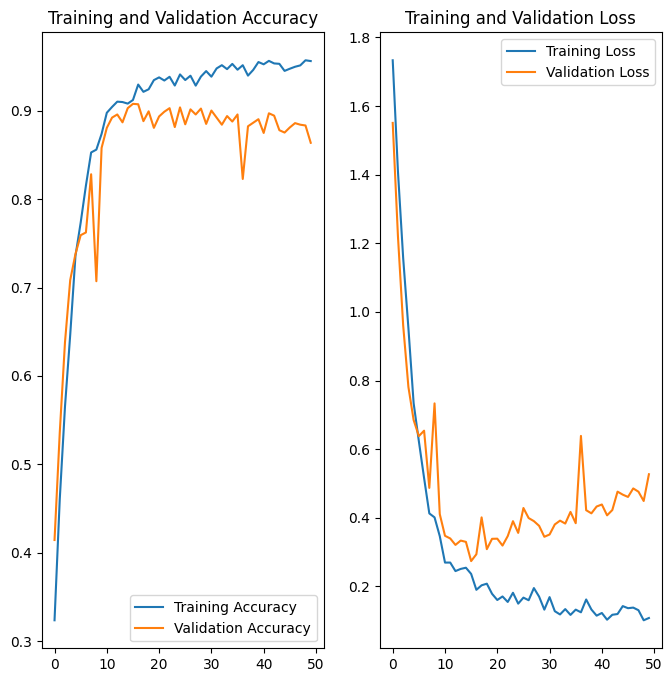

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. Overfitting is still there after augmentation.
2. But caugmentation helped the model increase it's accuracy.

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False  # Important for predictions
)

# Make predictions
predictions = model.predict(test_ds)
predicted_classes = predictions.argmax(axis=-1)

# If true labels are available
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Optionally save predictions to a CSV file
image_files = [f for f in test_ds.file_paths]
df = pd.DataFrame({
    'filename': image_files,
    'predicted_class': predicted_classes,
    'True Label': true_labels
})
df.to_csv('/content/save_predictions.csv', index=False)

# Evaluate if true labels are available
if true_labels:
    accuracy = accuracy_score(true_labels, predicted_classes)
    print(f"Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(true_labels, predicted_classes)
    print("Confusion Matrix:\n", cm)

    report = classification_report(true_labels, predicted_classes)
    print("Classification Report:\n", report)


Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Accuracy: 0.41
Confusion Matrix:
 [[ 7  1  0  2  2  3  1  0  0]
 [ 4  6  0  1  0  2  0  3  0]
 [ 1  2  6  2  2  1  1  1  0]
 [ 0  1  0  1 12  2  0  0  0]
 [ 0  0  0  0 15  1  0  0  0]
 [ 3  1  2  0  1  6  0  3  0]
 [ 0  0  0  2  0  0  0  1  0]
 [ 1  3  0  3  2  2  0  5  0]
 [ 0  1  0  0  0  0  0  0  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.44      0.44        16
           1       0.40      0.38      0.39        16
           2       0.75      0.38      0.50        16
           3       0.09      0.06      0.07        16
           4       0.44      0.94      0.60        16
           5       0.35      0.38      0.36        16
           6       0.00      0.00      0.00         3
           7       0.38      0.31      0.34        16
           8       1.00      0.67      0.80         3

    accuracy                           0.41       118